# Investigate numerical instability

Minimal working example is the following rule-layer mapping:

```python
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]
```

The issue arises depending on the implementation of the [`stabilize`](https://github.com/rodrigobdz/lrp/blob/c163c519599d0dd1320e8ed8cab5daac1978fe20/lrp/zennit/core.py#L16-L25) method.

The following implementations have been tested:

```python
epsilon: float = 0.1
dividend: torch.Tensor = torch.Tensor([-epsilon, 5, -5, -10])
# tensor([ -0.1000,   5.0000,  -5.0000, -10.0000])
```

1. **Heuristic:** Add epsilon to the absolute value of the dividend (zennit's) conserving the sign: 

    ```python
    dividend + ((dividend == 0.).to(dividend) + dividend.sign()) * epsilon
    ```

    Example:

    ```python
    dividend + ((dividend == 0.).to(dividend) + dividend.sign()) * epsilon
    # tensor([ -0.2000,   5.1000,  -5.1000, -10.1000])
    ```

2. **Heuristic:** Scale epsilon according to dividend's magnitude using quadratic mean
    
    ```python
    dividend + epsilon * (dividend**2).mean()**.5 + 1e-9
    ```

    Example:

    ```python
    dividend + epsilon * (dividend**2).mean()**.5 + 1e-9
    # tensor([ 0.5124,  5.6124, -4.3876, -9.3876])
    ```

3. Add epsilon to dividend without heuristics

    ```python
    dividend + epsilon
    ```

    Example:

    ```python
    dividend + epsilon
    # tensor([ 0.0000,  5.1000, -4.9000, -9.9000])

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Callable
import torchvision
import numpy
import torch
from lrp import norm, image

from lrp.rules import LrpZBoxRule, LrpGammaRule, LrpEpsilonRule, LrpZeroRule

from typing import List, Dict, Union, Tuple
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear
import lrp.rules as rules

from lrp.core import LRP

import lrp.plot
from matplotlib import pyplot as plt

# Normalization
norm_fn: Callable[[torch.Tensor], torch.Tensor] = norm.ImageNetNorm()

# Input data
from torchvision import transforms

import numpy
from lrp import image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
  transforms.ConvertImageDtype(torch.float),
  transforms.Normalize(mean, std)
])

inv_norm = transforms.Normalize(
  mean= [-m/s for m, s in zip(mean, std)],
  std= [1/s for s in std]
)

# Image is in RGB mode with range [0,1]
img_path = '../data/castle2.jpg'
img: numpy.array = image.load_normalized_img(img_path)
X = transform(img)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = norm_fn(torch.zeros(*shape))
high: torch.Tensor = norm_fn(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]

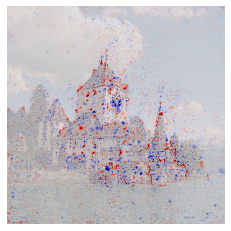

In [2]:
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

lrp_example = LRP(model)
lrp_example.convert_layers(name_map)

R: torch.Tensor = lrp_example.relevance(X)

fig, ax = plt.subplots()
img: numpy.array = image.load_normalized_img(img_path)
lrp.plot.heatmap(R[0].sum(dim=0).detach().numpy(), width=2, height=2, show_plot=False, fig=ax)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.ConvertImageDtype(torch.float),
])

ax.imshow(transform(img).numpy().transpose(1,2,0), alpha=0.2)
# fig.savefig('/Users/rodrigobermudezschettino/Downloads/castle_lrp.png', dpi=150)

In [3]:
# dividend + epsilon
a = R[0].sum(dim=0).detach()
print('Total', torch.numel(a))
print('negative', torch.numel(a[a < 0.]))
print('zero', torch.numel(a[a == 0.]))
print('positive', torch.numel(a[a > 0.]))

display(torch.aminmax(a))

Total 50176
negative 23813
zero 0
positive 26363


torch.return_types.aminmax(
min=tensor(-0.0600),
max=tensor(0.0619))

In [4]:
print(f'R {R.shape}')
print(f'X {X.shape}')
print(f'X.grad {X.grad.shape}')
print('\n')

a = (R[0].detach()==torch.max(R[0].detach())).nonzero()
i, h, k = a[0, :].tolist()

print(f'R max indices: {i} {h} {k}')

print(f'X max {X[0][i, h, k].item()}')
print(f'X.grad max {X.grad[0][i, h, k].item()}')
print(f'R max {R[0].detach()[i, h, k].item()}')

print('\n')

a = (R[0].detach()==torch.min(R[0].detach())).nonzero()
i, h, k = a[0, :].tolist()

print(f'R min indices: {i} {h} {k}')

print(f'X min {X[0][i, h, k].item()}')
print(f'X.grad min {X.grad[0][i, h, k].item()}')
print(f'R min {R[0].detach()[i, h, k].item()}')


print('\n')

# print('X max')
a = (X.grad==torch.max(X.grad)).nonzero()
z, i, h, k = a[0, :].tolist()

print(f'X.grad max indices: {z} {i} {h} {k}')
print(f'X max: {X[z, i, h, k].item()}')
print(f'X.grad max: {X.grad[z, i, h, k].item()}')

# print('\nX min')
print('\n')

a = (X.grad==torch.min(X.grad)).nonzero()
z, i, h, k = a[0, :].tolist()

print(f'X.grad min indices: {z} {i} {h} {k}')
print(f'X min: {X[z, i, h, k].item()}')
print(f'X.grad min: {X.grad[z, i, h, k].item()}')


R torch.Size([1, 3, 224, 224])
X torch.Size([1, 3, 224, 224])
X.grad torch.Size([1, 3, 224, 224])


R max indices: 1 91 82
X max -1.8270516395568848
X.grad max -0.0070962319150567055
R max 0.03121413104236126


R min indices: 1 167 102
X min -2.008283853530884
X.grad min 0.007749870419502258
R min -0.03281446546316147


X.grad max indices: 0 1 167 102
X max: -2.008283853530884
X.grad max: 0.007749870419502258


X.grad min indices: 0 1 91 82
X min: -1.8270516395568848
X.grad min: -0.0070962319150567055


In [5]:
print(torch.min(X.grad))
min_x_grad = (X.grad==torch.min(X.grad)).nonzero()
z, i, h, k = min_x_grad[0, :].tolist()

a = X[z, i, h, k].item()
b = X.grad[z, i, h, k].item()
print(f'X min {a} X.grad min {b}')
print(a*b)

r = R[0].detach()
print(r.shape)
display(torch.aminmax(r))

r = R[0].sum(dim=0).detach()
print(r.shape)
display(torch.aminmax(r))

# print(f'X.grad min indices: {z} {i} {h} {k}')
# print(f'X min: {X[z, i, h, k].item()}')

tensor(-0.0071)
X min -1.8270516395568848 X.grad min -0.0070962319150567055
0.012965182155080246
torch.Size([3, 224, 224])


torch.return_types.aminmax(
min=tensor(-0.0328),
max=tensor(0.0312))

torch.Size([224, 224])


torch.return_types.aminmax(
min=tensor(-0.0600),
max=tensor(0.0619))

In [6]:
# from torch.utils.tensorboard import SummaryWriter

# !rm -rf runs
# writer = SummaryWriter()
# writer.add_image('X.grad', X.grad[0])
# writer.add_image('X * X.grad',X[0]*X.grad[0])
# writer.close()